

```
# Código Exemplo: Autoencoders
# Adaptado de https://blog.keras.io/building-autoencoders-in-keras.html
# mlflow server --backend-store-uri=sqlite:///mlflow.db
```



Autoencoder: Versão mais simples possível!

## Imports

In [1]:
import keras

from keras import layers
from keras.models import Sequential
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK
from hyperopt.pyll import scope as ho_scope
from hyperopt.pyll.stochastic import sample as ho_sample

import mlflow

import pandas as pd
import numpy as np

---
### Dataset

In [2]:
df = pd.read_csv('models\milk_0_val\milk_updated.csv', index_col=['AnEar', 'Date'])

In [3]:
def serialization(dataframe: pd.DataFrame):
    series = []
    for vaca in dataframe.index.levels[0]:
        series.append(dataframe.loc[vaca])
    return np.array(series).squeeze()

In [4]:
series = serialization(df)

In [5]:
import sklearn
import sklearn.model_selection

train, test = sklearn.model_selection.train_test_split(series,
                                                       train_size=0.8,
                                                       random_state=10,
                                                       shuffle=True,
                                                       )
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(train)

train = scaler.transform(train)
test = scaler.transform(test)

In [6]:
from keras.datasets import mnist
import numpy as np
(x_train, _), (x_test, _) = mnist.load_data()

In [7]:
x_train = x_train.astype('float32') / 255.
#x_train = x_train.astype('float32')
x_test = x_test.astype('float32') / 255.
#x_test = x_test.astype('float32')
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


---
### Criação do Modelo

#### Undercomplete Autoencoder

In [8]:
import keras.layers

def undercomplete_create(parameters: dict, size: int):
    dim = list(parameters['dim'])
    for i in range(parameters['intermediate']):
        if (dim[i] > dim[i-1]) & (i>0):
            dim[i] = dim[i-1]
        if dim[i] < parameters['encoder_out']:
            dim[i]=parameters['encoder_out']


    model = Sequential()
    model.add(keras.Input(shape=(size,)))

    for i in range(parameters['intermediate']):
        model.add(layers.Dense(units=dim[i],
                               activation=parameters['activation']
                               ))
        if parameters['dropout'] in [1, 2]:
            model.add(keras.layers.Dropout(parameters['dropout_rate'], seed=10))
    
    
    ################# ENCODER OUTPUT #################
    model.add(layers.Dense(units=parameters['encoder_out'],
                           activation=parameters['activation']
                           ))
    ##################################################

    for i in range(parameters['intermediate']):
        model.add(layers.Dense(units=dim[parameters['intermediate']-i-1],
                               activation=parameters['activation']
                               ))
        if parameters['dropout'] in [2]:
            model.add(keras.layers.Dropout(parameters['dropout_rate'], seed=10))

    model.add(layers.Dense(units=size, activation=parameters['out_activation']))
    
    return model

---
#### Sparse Autoencoder

In [9]:
import keras.layers
import keras.regularizers


def sparse_create(parameters: dict, size: int):
    dim = list(parameters['dim'])
    for i in range(parameters['intermediate']):
        if (dim[i] > dim[i-1]) & (i>0):
            dim[i] = dim[i-1]
        if dim[i] < parameters['encoder_out']:
            dim[i]=parameters['encoder_out']
    
    model = Sequential()
    model.add(keras.Input(shape=(size,)))

    for i in range(parameters['intermediate']):
        model.add(layers.Dense(units=dim[i],
                               activation=parameters['activation'],
                               #activity_regularizer=keras.regularizers.L1(0.01),
                               ))
        
    ################# ENCODER OUTPUT #################
    model.add(layers.Dense(units=parameters['encoder_out'],
                           activation=parameters['activation'],
                           activity_regularizer=keras.regularizers.L1(0.0001),
                           ))
    ##################################################

    for i in range(parameters['intermediate']):
        model.add(layers.Dense(units=dim[parameters['intermediate']-1-i],
                               activation=parameters['activation'],
                               #activity_regularizer=keras.regularizers.L1(0.01),
                               ))

    model.add(layers.Dense(units=size, activation=parameters['out_activation']))
    
    return model

In [10]:
def autoencoder_create(parameters: dict, size: int):
    if parameters['type'] == 'undercomplete':
        model = undercomplete_create(parameters, size)
    elif parameters['type'] == 'sparse':
        model = sparse_create(parameters, size)

    return model

In [11]:
import keras.optimizers

def create_optimizer(parameters):
    if parameters['optimizer']=='adam':
        optimizer = keras.optimizers.Adam(learning_rate=parameters['learning_rate'])
    elif parameters['optimizer']=='sgd':
        optimizer = keras.optimizers.SGD(learning_rate=parameters['learning_rate'])
    elif parameters['optimizer']=='rmsprop':
        optimizer = keras.optimizers.RMSprop(learning_rate=parameters['learning_rate'])  
    else:
        optimizer = keras.optimizers.Adam()      
    return optimizer

---
#### Train Autoencoder

In [12]:
def train_autoencoder(model: keras.Model,
                      train_params: dict,
                      train_dataset,
                      val_dataset,
                      ):
    
    optimizer = create_optimizer(parameters=train_params)

    model.compile(optimizer=optimizer,
                  loss='MeanSquaredError',
                  metrics=['mae'],
                  )

    early = EarlyStopping(monitor='val_loss',
                          mode='min',
                          patience=train_params['early_stop_patience'],
                          restore_best_weights=True,
                          )
    
    callback_list = [early]

    hist = model.fit(x=train_dataset,
                     y=train_dataset,
                     batch_size=train_params['batch_size'],
                     epochs=train_params['epochs'],
                     verbose=0,
                     validation_data=(val_dataset, val_dataset),
                     callbacks=callback_list,
                     )
    
    return model, hist

In [13]:
import mlflow.keras


def run_autoencoder(parameters):
    mlflow.sklearn.autolog(disable=True)
    size = 305

    with mlflow.start_run(run_name='autoencoder'):
        mlflow.set_tag("model_name", "AE")

        mlflow.log_params(parameters['create'])
        mlflow.log_params(parameters['train'])


        model = autoencoder_create(parameters=parameters['create'],
                                   size=size,
                                   )
        
        model, _ = train_autoencoder(model=model,
                                     train_params=parameters['train'],
                                     train_dataset=parameters['train_dataset'],
                                     val_dataset=parameters['val_dataset'],
                                     )

        score, acc = model.evaluate(parameters['val_dataset'],
                                    parameters['val_dataset'],
                                    verbose=0)

        mlflow.log_metrics({'score': score, 'error': acc})

        mlflow.keras.log_model(model, "ae_models")

        print(f'\nTest accuracy: {acc}\n')
        
    return {'loss': score, 'status': STATUS_OK, 'model': model}

---
### Hyperparameters optimization

In [14]:
hp_space = {
    'create': {'encoder_out': 50,
                'dim': [ho_scope.int(hp.quniform('1',
                                                 low=0,
                                                 high=305,
                                                 q=1),
                                                 ),
                        ho_scope.int(hp.quniform('2',
                                                 low=0,
                                                 high=305,
                                                 q=1),
                                                 ),
                        ho_scope.int(hp.quniform('3',
                                                 low=0,
                                                 high=305,
                                                 q=1),
                                                 ),
                        ho_scope.int(hp.quniform('4',
                                                 low=0,
                                                 high=305,
                                                 q=1),
                                                 ),
                        ho_scope.int(hp.quniform('5',
                                                 low=0,
                                                 high=305,
                                                 q=1),
                                                 ),],
               'intermediate': ho_scope.int(hp.quniform('intermediate',
                                                        low=0,
                                                        high=5,
                                                        q=1),
                                                        ),
               'activation': hp.choice('activation',
                                        ['relu',
                                         #'softmax',
                                         'sigmoid',
                                         ]),

               'out_activation': hp.choice('out_activation',
                                            ['relu',
                                             #'softmax',
                                             'sigmoid',
                                             ]),

               'dropout' : hp.choice('dropout', [0, 1, 2]),
               'dropout_rate' : hp.quniform('dropout_rate',
                                            low=0.05,
                                            high=0.4,
                                            q=0.05),

               'type' : hp.choice('type',
                                   ['sparse',
                                    'undercomplete',
                                    ]),
               },

    'train': {'epochs': ho_scope.int(hp.quniform('epochs',
                                                 low=50,
                                                 high=300,
                                                 q=10
                                                 )),
                'optimizer': hp.choice('optimizer',
                                       ['adam',
                                        'sgd',
                                        'rmsprop'
                                        ]),

              'learning_rate': hp.quniform('learning_rate',
                                           low=0.0005,
                                           high=0.002,
                                           q=0.0005,
                                           ),
                                           
              'early_stop_patience': ho_scope.int(
                  hp.quniform('early_stop_patience', low=0, high=100, q=10)),
              'batch_size': hp.choice('batch_size', [ 1, 2, 4, 8, 16])
              },

    'train_dataset': train,
    'val_dataset': test,
}

In [15]:
mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("autoencoder_milk")

<Experiment: artifact_location=('file:///c:/Users/Caio/OneDrive/ARQUIVOS/ACADEMICO/4-POS-GRAD '
 'IA/2024-1-MODULO 3/3-DEEP LEARNING/AVALIACAO/mlruns/2'), creation_time=1716390470395, experiment_id='2', last_update_time=1716390470395, lifecycle_stage='active', name='autoencoder_milk', tags={}>

In [16]:
trials = Trials()

In [17]:
best_clf = fmin(fn = run_autoencoder,
                space = hp_space,
                algo = tpe.suggest,
                max_evals = 30,
                trials = trials,
                verbose=False,
                )

  0%|          | 0/30 [00:00<?, ?trial/s, best loss=?]

2024/05/22 16:57:33 WARNING mlflow.utils.git_utils: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
    - be included in your $PATH
    - be set via $GIT_PYTHON_GIT_EXECUTABLE
    - explicitly set via git.refresh()

All git commands will error until this is rectified.

This initial warning can be silenced or aggravated in the future by setting the
$GIT_PYTHON_REFRESH environment variable. Use one of the following values:
    - quiet|q|silence|s|none|n|0: for no warning or exception
    - warn|w|warning|1: for a printed warning
    - error|e|raise|r|2: for a raised exception

Example:
    export GIT_PYTHON_REFRESH=quiet


2024/05/22 16:57:48 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc

INFO:tensorflow:Assets written to: C:\Users\Caio\AppData\Local\Temp\tmppl_ozq9l\model\data\model\assets
                                                      
Test accuracy: 0.06784816086292267

  3%|▎         | 1/30 [00:36<17:48, 36.84s/trial, best loss: 0.009484715759754181]

c:\Users\Caio\anaconda3\envs\tf\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")

2024/05/22 16:58:20 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.



INFO:tensorflow:Assets written to: C:\Users\Caio\AppData\Local\Temp\tmpyqgclzg4\model\data\model\assets
  3%|▎         | 1/30 [01:00<29:17, 60.61s/trial, best loss: 0.009484715759754181]


In [29]:
best_clf

{'epochs': 30.0, 'intermediate': 1.0, 'out_activation': 1}

In [14]:
logged_model = 'runs:/f1d27c10689e4fbf970ec56cfc1a3ce2/ae_models'
autoencoder = mlflow.pyfunc.load_model(logged_model)

In [224]:
# Encode and decode some digits
# Note that we take them from the *test* set
#encoded_imgs = autoencoder.predict(x_test)
encoded_imgs = model.predict(x_test)

#decoded_imgs = decoder.predict(encoded_imgs)

313/313 [==============================] - 0s 1ms/step


In [225]:
model.evaluate(x_test,x_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.0072 - mae: 0.0260


[0.007154164835810661, 0.026019183918833733]

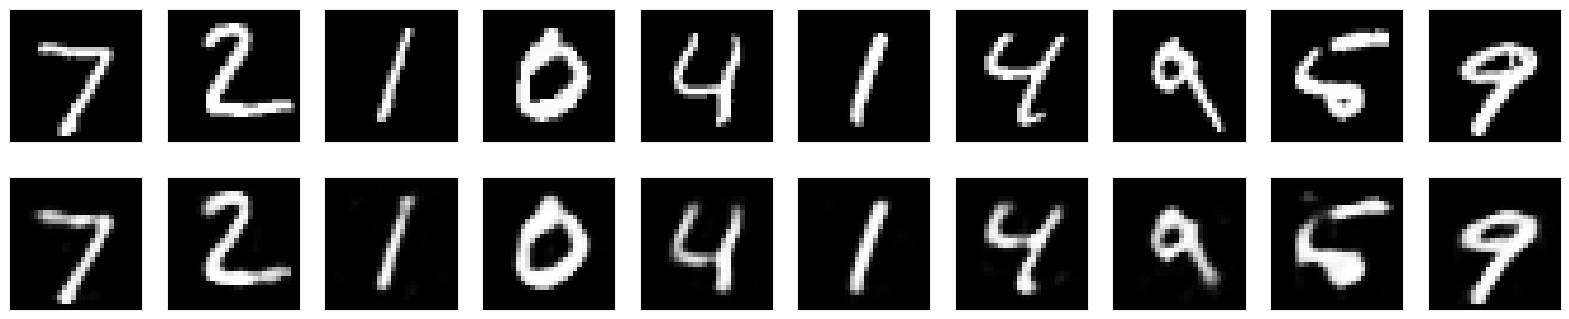

In [226]:
# Use Matplotlib (don't ask)
import matplotlib.pyplot as plt

n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(encoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [29]:
import pandas as pd
import matplotlib.pyplot as plt

pd.DataFrame(hist.history)

,loss,root_mean_squared_error,val_loss,val_root_mean_squared_error
0,0.237090,0.239667,0.157878,0.176987
1,0.138415,0.157416,0.124623,0.143248
2,0.118340,0.135067,0.111195,0.126830
3,0.108474,0.122656,0.103780,0.116610
4,0.102842,0.115030,0.099292,0.110182
5,0.099078,0.109650,0.096255,0.105684
6,0.096335,0.105588,0.093773,0.101962
7,0.094197,0.102358,0.092369,0.099574
8,0.092365,0.099477,0.090630,0.097188
9,0.090824,0.097004,0.088932,0.094196


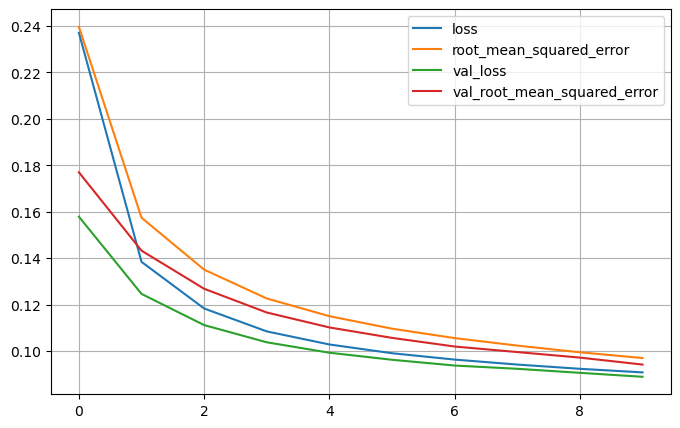

In [20]:
pd.DataFrame(hist.history).plot(figsize=(8,5))
plt.grid(True)
#plt.gca().set_ylim(0,0.2)
plt.show()

In [ ]:
history = autoencoder.fit(x=x_train,
                          y=x_train,
                          epochs=10,
                          batch_size=256,
                          shuffle=True,
                          validation_data=(x_test, x_test))

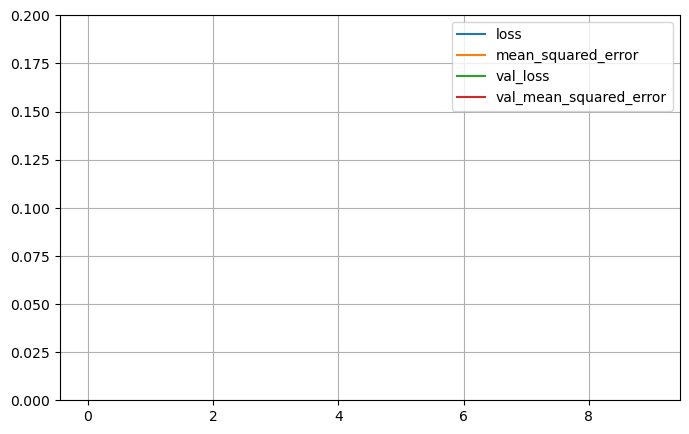

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,0.2)
plt.show()